<a href="https://colab.research.google.com/github/sn0rkmaiden/rnn-practice/blob/main/RNN_and_Shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 1.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import torch
import torch.nn as nn
import unidecode
import string
import random
import re
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
all_characters = string.printable
n_characters = len(all_characters)

# file_path="/content/drive/MyDrive/shakespeare.txt"
# file_path="/content/drive/MyDrive/alice_in_wonderland.txt"
file_path="/content/drive/MyDrive/cpp.txt"

data = unidecode.unidecode(open(file_path).read())
vocab_size = len(data)
print('file_len =', vocab_size)

file_len = 808920


In [8]:
chars = sorted(list(set(data)))

bad_chars = ['#', '*', '@', '_', '\ufeff']
for i in range(len(bad_chars)):
    data = data.replace(bad_chars[i], "")

chars = list(set(data))

In [25]:
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
data_size, vocab_size

(808920, 97)

In [26]:
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

In [27]:
chunk_len = 200
hidden_size = 100
seq_len = 25

def random_chunk():
    start_index = random.randint(0, data_size - chunk_len)
    end_index = start_index + chunk_len + 1
    return data[start_index:end_index]

print(random_chunk())

pr.value = c_build_function_call_vec (loc, arg_loc, fndecl,
						    args, origtypes);
	    set_c_expr_source_range (&expr, loc, close_paren_loc);
	    if (expr.value == error_mark_node)
	      break;


**Backprop and code:**

1.   https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/
2.   https://mkffl.github.io/2019/07/08/minimalist-RNN.html






In [28]:
class RNN(nn.Module):
  def __init__(self, hidden_size, vocab_size):
    super(RNN, self).__init__()
    self.hidden = np.zeros((hidden_size, 1))
    self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
    self.Wxh = np.random.randn(hidden_size, vocab_size) * 0.01
    self.Why = np.random.randn(vocab_size, hidden_size) * 0.01
    self.bh = np.zeros((hidden_size, 1))
    self.by = np.zeros((vocab_size, 1))

  def forward(self, x, hprev):
    hidden = np.tanh(np.dot(self.Whh, hprev) + np.dot(self.Wxh, x) + self.bh)
    y = np.dot(self.Why, hidden) + self.by
    return hidden, y

  def calculate_probs(self, y):
    return np.exp(y) / np.sum(np.exp(y))

  def calc_loss(self, inputs, targets, hprev=None):
    loss = 0
    xs, hs, ys, ps = {}, {}, {}, {}
    hs[-1] = np.zeros((hidden_size, 1))
    if hprev is not None:
      hs[-1] = np.copy(hprev)

    for t in range(len(inputs)):
      xs[t] = np.zeros((vocab_size, 1))
      xs[t][inputs[t]] = 1
      hs[t], ys[t] = self.forward(xs[t], hs[t-1])
      ps[t] = self.calculate_probs(ys[t])
      loss += -np.log(ps[t][targets[t]][0])

    return loss, hs[len(inputs) - 1], xs, hs, ps

  def backward(self, inputs, targets, xs, hs, ps):
    dWxh, dWhh, dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
    dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
    dhnext = np.zeros_like(hs[0])

    for t in reversed(range(len(inputs))):
      dy = np.copy(ps[t])
      dy[targets[t]] -= 1 # softmax loss

      dWhy += np.dot(dy, hs[t].T)
      dby += dy
      dh = np.dot(self.Why.T, dy) + dhnext
      dhraw = (1 - hs[t] * hs[t]) * dh
      dbh += dhraw
      dWxh += np.dot(dhraw, xs[t].T)
      dWhh += np.dot(dhraw, hs[t-1].T)
      dhnext = np.dot(self.Whh.T, dhraw)
      for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients

    return dWxh, dWhh, dWhy, dbh, dby

In [29]:
model = RNN(hidden_size, vocab_size).to(device)

In [30]:
n, p = 0, 0
epochs = 5000 * 2
learning_rate = 1e-1
smooth_loss = -np.log(1.0 / vocab_size) * seq_len # loss at iteration 0

losses = []

mWxh, mWhh, mWhy = np.zeros_like(model.Wxh), np.zeros_like(model.Whh), np.zeros_like(model.Why)
mbh, mby = np.zeros_like(model.bh), np.zeros_like(model.by) # memory variables for Adagrad

for i in range(epochs):

  if p + seq_len + 1 >= len(data) or i == 0:
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    p = 0 # go from start of data

  inputs = [char_to_ix[ch] for ch in data[p:p + seq_len]]
  targets = [char_to_ix[ch] for ch in data[p + 1 : p + seq_len + 1]]

  loss, hprev, xs, hs, ps = model.calc_loss(inputs, targets, hprev)
  dWxh, dWhh, dWhy, dbh, dby = model.backward(inputs, targets, xs, hs, ps)
  # print(loss)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  if i % 100 == 0:
    # print('iter %d, loss: %f' % (i, smooth_loss)) # print progress
    losses.append(smooth_loss)
  if i % 1000 == 0: print('iter %d' % i) # print progress

  for param, dparam, mem in zip([model.Wxh, model.Whh, model.Why, model.bh, model.by],
                                [dWxh, dWhh, dWhy, dbh, dby],
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

  p += seq_len

iter 0
iter 1000
iter 2000
iter 3000
iter 4000
iter 5000
iter 6000
iter 7000
iter 8000
iter 9000


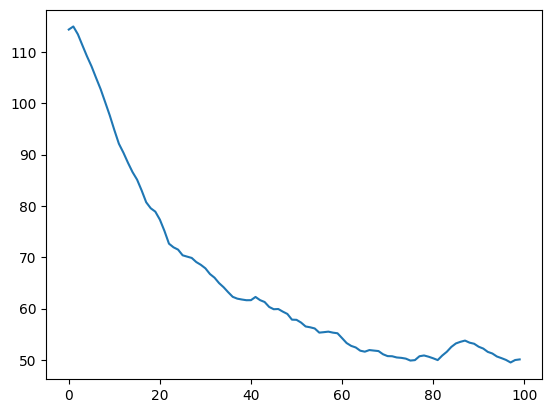

In [31]:
plt.plot(losses)
plt.show()

In [33]:
def sample_chars(hidden_state, seed_idx, num_seq):
      """Sample a sequence of characters from the current model, this is primarily used for test time"""
      x = np.zeros((vocab_size, 1))
      x[seed_idx] = 1
      indices = []
      for _ in range(num_seq):
          # hidden_state = tanh(dot(self.params['Wxh'], x) + dot(self.params['Whh'], hidden_state) + self.params['Bh'])
          # output = dot(self.params['Why'], hidden_state) + self.params['By']
          hidden_state, output = model(x, hidden_state)
          # prob = exp(output) / np.sum(exp(output))
          prob = model.calculate_probs(output)
          idx = np.random.choice(range(vocab_size), p=prob.ravel())  # ravel() flattens the matrix
          x = np.zeros((vocab_size, 1))
          x[idx] = 1
          indices.append(idx)

      return hidden_state, indices

In [36]:
letter = '#'
hidden_state = np.zeros_like((hidden_size, 1))
_, sampled_indices = sample_chars(hprev, char_to_ix[letter], 500)
predicted_text = ''.join(ix_to_char[idx] for idx in sampled_indices)
print("-------------\n%s\n-------------" % predicted_text)

-------------
rengien (parser, CqSIiex
  i- ebtign,
 wh atiter_lee  nex;
{
  se
		  if (laration (tqulc_lordatisemt);
    c_parser_lon_token'tr, tre (parser);
  if (pre:

 }

   dec_e bwol (xpemonins,
}

  = sterd brer_tutes (trse_loc_ool_arde), aplr_exkent_parser, ersion (da thed aldec if (^peepwespexp__loc, tyty st_cd_acd_bols Cppoc_Fola_tome rinils altrst_wy)
  }
   attnobenind lokons_war atinect_vecstst_pelndtalat
    faUso [ok_t_tregte_lidqolw*;
	{
	  brec_coc_extbuc)->ifsumeme in+-token (saif_tifiund_sm
-------------
